In [5]:
import midas.file_reader
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import cygno as cy
class myError(Exception):
    pass

verbose = False

def ped_mid(run, path_file='/s3/cygno-data/', path_ped='./ped/', tag = 'LNGS', 
            cloud=False, verbose=False):
    #
    # VERSIONE con PY al posto di root file. 
    #
    # run numero del run
    # path path lettura/scrittura piedistalli
    # tag subdirectory dei dati
    # min_image_to_read , max_image_to_read  range di imagine sul quale fare i piedistalli 
    # max_image_to_read = 0 EQUIVALE A TUTTE LE IMMAGINI
    #
    # 
    import numpy as np
    import tqdm
    import os
    import midas.file_reader
    # funzione per fare i piedistalli se gia' non esistino nella diretory

    fileoutm = (path_ped+"mean_Run{:05d}".format(run))
    fileouts = (path_ped+"sigma_Run{:05d}".format(run))

    if os.path.exists(fileoutm+".npy") and os.path.exists(fileouts+".npy"): 
        # i file gia' esistono
        m_image = np.load(fileoutm+".npy")
        s_image = np.load(fileouts+".npy")
        print("RELOAD maen file: {:s} sigma file: {:s}".format(fileoutm, fileouts))
        return m_image, s_image
    else:
        # i file non esistono crea il file delle medie e delle sigma per ogni pixel dell'immagine
        if verbose: print (">>> Pedestal Maker! <<<")
        try:
            mfile = cy.open_mid(run=run, path=path_file, cloud=cloud, tag=tag, verbose=verbose)
        except:
            raise myError("openRunError: "+str(run))
            
        init=True
        for event in mfile:
            if event.header.is_midas_internal_event():
                continue
            bank_names = ", ".join(b.name for b in event.banks.values())
            for bank_name, bank in event.banks.items():
                if bank_name=='CAM0': # CAM image
                    image, shape_x_image, shape_y_image = cy.daq_cam2array(bank)
                    if init:
                        m_image = np.zeros((shape_x_image, shape_y_image), dtype=np.float64)
                        s_image = np.zeros((shape_x_image, shape_y_image), dtype=np.float64)

                        n0 = 0
                        init=False
                    #image[image<0]=99 #pach per aclune imagini
                    m_image += image
                    s_image += image**2 
                    n0 += 1

                    if verbose and n0 > 0 and n0 % 10==0:  # print progress and debung info for poit pixel
                        px=1000
                        print ("Debug Image[200,200]: %d => %.2f %.2f %.2f" % (n0,
                                                        image[px,px],
                                                        m_image[px,px]/n0, 
                                                        np.sqrt((s_image[px,px] - (m_image[px,px]**2) / n0) / (n0+1))))
                    
        m_image = m_image/n0    
        s_image = np.sqrt((s_image - m_image**2 * n0) / (n0 - 1))
        m_image[np.isnan(s_image)==True]=m_image.mean() # pach per i valori insani di sigma e media
        s_image[np.isnan(s_image)==True]=1024
        ###### print Info and Save OutPut ######################################
        print("WRITING ...")
        np.save(fileoutm+".npy", m_image)
        np.save(fileouts+".npy", s_image)
        print("DONE OUTPUT maen file: {:s} sigma file: {:s}".format(fileoutm, fileouts))
        return m_image, s_image

def imege_adder(mfile):
    nTr = 10000000
    iTr = 0
    images = np.zeros((2304, 2304), dtype=np.float64)
    for event in mfile:
        if iTr<=nTr:
            if event.header.is_midas_internal_event():
                print("Saw a special event")
                continue

            bank_names = ", ".join(b.name for b in event.banks.values())

            for bank_name, bank in event.banks.items():
                if bank_name=='CAM0': # CAM image
                    image, _, _ = cy.daq_cam2array(bank)
                    images +=(image-m_image)

            if verbose or (iTr%10)==0:  
                print (" processing imege %d " % (iTr))
            iTr += 1     
        else:
            break
    return images/iTr

m_image, s_image = ped_mid(run=12112, path_ped='./ped/', tag = 'LNF', 
     cloud=False, verbose=verbose)
mfile = cy.open_mid(run=12113, path='/s3/cygno-data/', cloud=False, tag='LNF', verbose=verbose)
image1 = imege_adder(mfile)
mfile = cy.open_mid(run=12114, path='/s3/cygno-data/', cloud=False, tag='LNF', verbose=verbose)
image2 = imege_adder(mfile)


print("ALL DONE")

RELOAD maen file: ./ped/mean_Run12112 sigma file: ./ped/sigma_Run12112
Saw a special event
 processing imege 0 
 processing imege 10 
 processing imege 20 
 processing imege 30 
 processing imege 40 
 processing imege 50 
 processing imege 60 
 processing imege 70 
 processing imege 80 
 processing imege 90 
 processing imege 100 
 processing imege 110 
 processing imege 120 
 processing imege 130 
 processing imege 140 
 processing imege 150 
 processing imege 160 
 processing imege 170 
 processing imege 180 
 processing imege 190 
 processing imege 200 
 processing imege 210 
 processing imege 220 
 processing imege 230 
 processing imege 240 
 processing imege 250 
 processing imege 260 
 processing imege 270 
 processing imege 280 
 processing imege 290 
 processing imege 300 
 processing imege 310 
 processing imege 320 
Saw a special event
Saw a special event
 processing imege 0 
 processing imege 10 
 processing imege 20 
 processing imege 30 
 processing imege 40 
 processing 

In [6]:
images = (image1+image2)/2

In [13]:
images.min(), images.max(), images.mean(), 

(-8.119581447963837, 4.665588235294123, 0.009363146818627809)

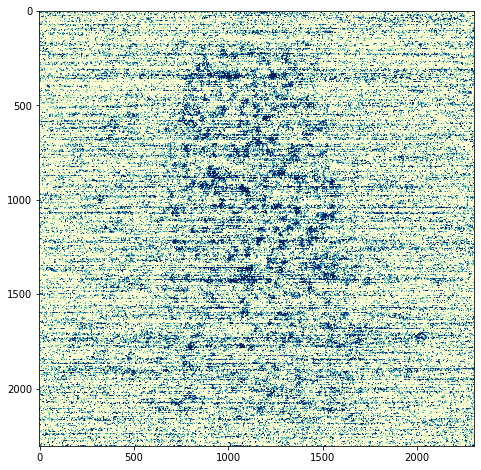

In [19]:
plt.figure(figsize=(8,8))
plt.imshow(images, vmin=0, vmax=0.1, cmap='YlGnBu')
plt.show()